# Metropolis-Hastingsアルゴリズム

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

## 目的分布: $p(z)$

任意の$z$に対して$\tilde{p}(z) = Z_p p(z)$のみが計算できる: パラメタ$a>0, b>0$が所与のものとして,

$$
\tilde{p}(z | a, b) = b^a z^{a-1} \exp (-bz)
$$

ただし, $z>0$とする.

In [ ]:
def tilde_p(z, a, b):
    return (b**a) * (z ** (a-1)) * np.exp(-b * z)

print(tilde_p(-1, 2, 1))

-2.718281828459045


以下では, パラメタ$a, b$について

$$
a = 2.75 \\
b = 0.9
$$

とする

In [ ]:
a = 2.75
b = 0.9

## 提案分布: $q(z | z^{(\tau)})$

サンプリングが容易な分布. 分散$\sigma^2$が所与であるとして,

$$
q(z | z^{(\tau)}, \sigma^2) = \mathcal{N}(z | z^{(\tau)}, \sigma^2) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \left( - \frac{{(z - z^{(\tau)})}^2}{2 \sigma^2} \right)
$$

累積分布の逆関数からのサンプリングが難しいので, Polar法を用いて$\mathcal{N}(0, 1^2)$からサンプリングし, $\sigma$倍して$z^{(\tau)}$を加算することで代用する.

後述の手続きより, サンプリングは(基本的に)1度ずつしか行われない.

In [ ]:
def q(z, z_tau, sigma):
    return (1 / np.sqrt(2 * np.pi * (sigma ** 2))) * np.exp(-((z - z_tau) ** 2) / (2 * (sigma ** 2)))

def sample_q(z_tau, sigma, size=1, rng=np.random.default_rng()):
    li = []
    while True:
        u = rng.uniform(-1,1,2)

        s = u[0] ** 2 + u[1] ** 2
        if s > 1: continue

        c = np.sqrt(-2 * np.log(s)/s)
        li.append(c * u[0])
        li.append(c * u[1])

        if len(li) >= size: break

    return np.array(li[:size]) * sigma + z_tau

$z^{(\tau)}$は学習途中で変化するので、初期値$z^{(0)} = 5$とする(あえてよくない初期値). $\sigma^2$は$1.5$にでもしとこ

In [ ]:
z_0 = 5
sigma = 1.5

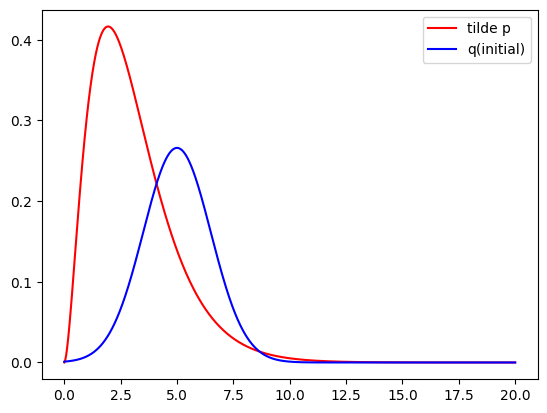

In [ ]:
fig, ax = plt.subplots(1, 1)
z = np.linspace(0, 20, 1000)

ax.plot(z, tilde_p(z, a, b), "r-", label="tilde p")
ax.plot(z, q(z, z_0, sigma), "b-", label="q(initial)")
ax.legend()

## Metropolis-Hastingsアルゴリズムの手順

1. 乱数$z^*$を$q(z | z^{(\tau)})$からサンプリング
2. 確率$A(z^*, z^{(\tau)})$で採択.
    - もし採択されたら, $z^{(\tau + 1)} \leftarrow z^*$
    - もし棄却されたら, $z^{(\tau + 1)} \leftarrow z^{\tau}$

ここで, 採択確率$A(z^*, z^{(\tau)})$は

$$
A(z^*, z^{(\tau)}) = \min \left( 1, \frac{\tilde{p}(z^*) q(z^{(\tau)} | z^*)}{\tilde{p}(z^{(\tau)}) q(z^* | z^{(\tau)})} \right)
$$

最初の方の$z^*$は"質が悪い"ので更新則に用いたり用いなかったりした後は破棄. 収束したら(採択されたものを)サンプルとして保存する.
- 収束判定は色々ある(状態の変化の度合いとか)が, とりあえず今は特に収束判定基準を設けず一定回数の更新で収束したとみなす

In [ ]:
PRE = 1000 # n_iters to converge
rng = np.random.default_rng()

z_tau = z_0
status = []
for _ in range(PRE):
    status.append(z_tau)

    z_star = sample_q(z_tau, sigma, size=1, rng=rng)[0]
    if z_star < 0: continue

    a_proba = (tilde_p(z_star, a, b) * q(z_tau, z_star, sigma)) / (tilde_p(z_tau, a, b) * q(z_star, z_tau, sigma))
    # a_proba = tilde_p(z_star, a, b) / tilde_p(z_tau, a, b)

    if rng.uniform(0, 1) > a_proba: continue
    z_tau = z_star

最後の100回での状態変化をプロット

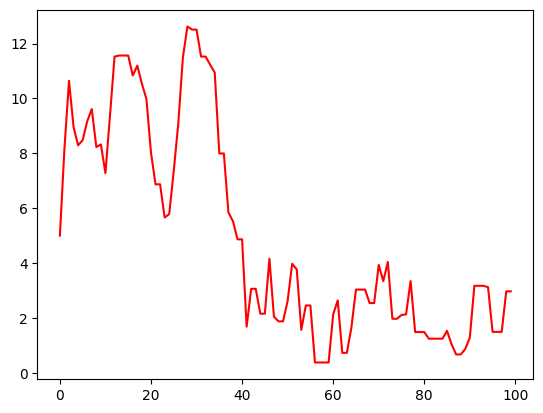

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.plot(range(len(status[:100])), status[:100], "r-")

$\cdots$これほんとに収束してるか?

まあ一旦収束したと仮定します. $z^{(\tau)}$をサンプルとして収集していく

In [ ]:
size = 10000

samples = []
for _ in range(size):
    samples.append(z_tau)
    z_star = sample_q(z_tau, sigma, size=1, rng=rng)[0]
    if z_star < 0: continue

    a_proba = (tilde_p(z_star, a, b) * q(z_tau, z_star, sigma)) / (tilde_p(z_tau, a, b) * q(z_star, z_tau, sigma))
    # a_proba = tilde_p(z_star, a, b) / tilde_p(z_tau, a, b)

    if rng.uniform(0, 1) > a_proba: continue
    z_tau = z_star

## 答え合わせ

目的分布$p(z)$は実はガンマ分布$\text{Gam}(z | a, b)$であった:

$$
\text{Gam}(z | a, b) = \frac{b^a z^{a-1} \exp (-bz)}{\Gamma (a)}
$$

これの期待値や分散は以下で与えられる:

$$
\begin{align}
\mathbb{E}[z] &= \frac{a}{b} \\
\text{Var}[z] &= \frac{a}{b^2} \\
\end{align}
$$

サンプリングされた$z$の平均や分散と比較してみる

In [ ]:
print("平均, 分散")
print(a/b, a/(b*b))
print(np.mean(samples), np.var(samples))

平均, 分散
3.0555555555555554 3.3950617283950617
3.1419514189617903 3.6278463048996605


うーんまずまずかねー

棄却サンプリングと違って良いパラメタを与えられているわけでもないからこんなもんか


- ある程度$z^{\tau}$を固めてしまったら棄却サンプリングするのもありかも?

おまけ

- 今回の設定では提案分布が対称であるためMetropolisアルゴリズムで十分
- 変化が急激すぎるのならハイパラ$\lambda$でもおいて$z^{(\tau+1)} = \lambda z^* + (1-\lambda) z^{(\tau)}$とでもすればいいんじゃない? 知らんけど